(faster_sampling_notebook)=

# Faster Sampling with JAX and Numba

:::{post} July 11, 2023
:tags: hierarchical model, JAX, numba, scaling
:category: reference, intermediate
:author: Thomas Wiecki
:::


PyMC offers multiple sampling backends that can dramatically improve performance depending on your model size and requirements. Each backend has distinct advantages and is optimized for different use cases.

### PyMC's Built-in Sampler

```python
pm.sample()
```

The default PyMC sampler uses a Python-based NUTS implementation that provides maximum compatibility with all PyMC features. This sampler is required when working with models that contain discrete variables, as it's the only option that works together with other non-gradient based samplers like Slice and Metropolis. While this sampler can compile the underlying model to different backends (C, Numba, PyTensor or JAX) using PyTensor's compilation system via the `compile_kwargs` parameter, it maintains Python overhead that can limit performance, particularly for small models.

### Nutpie Sampler

```python
pm.sample(nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "numba"})
pm.sample(nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "jax"})
pm.sample(nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "pytensor"})
```

Nutpie is PyMC's cutting-edge performance sampler. Written in Rust, it eliminates Python overhead and provides exceptional performance for continuous models. In addition, it has an improved NUTS adaptation algorithm that generalizes mass matrix adaptation from affine functions to arbitrary diffeomorphisms. This helps to identify transformations that adapt to the posterior’s scale and shape. The Numba backend typically offers the highest performance for most use cases, while the JAX backend excels with very large models and provides GPU acceleration capabilities. Nutpie is particularly well-suited for production workflows where sampling speed is critical.

### NumPyro Sampler

```python
pm.sample(nuts_sampler="numpyro", nuts_sampler_kwargs={"chain_method": "parallel"})
# GPU-accelerated
pm.sample(nuts_sampler="numpyro", nuts_sampler_kwargs={"chain_method": "vectorized"})
```

NumPyro provides a mature JAX-based sampling implementation that integrates seamlessly with the broader JAX ecosystem. This sampler benefits from years of development within the JAX community and provides reliable performance characteristics, with excellent GPU support for accelerated computation.

### BlackJAX Sampler

```python
pm.sample(nuts_sampler="blackjax")
```

BlackJAX offers another JAX-based sampling implementation focused on flexibility and research applications. While it provides similar capabilities to NumPyro, it's less commonly used in production environments. BlackJAX can be valuable for experimental workflows or when specific JAX-based features are required.


## Installation Requirements

To use the various sampling backends, you need to install the corresponding packages. Nutpie is the recommended high-performance option and can be installed with pip or conda/mamba (e.g. `conda install nutpie`). For JAX-based workflows, NumPyro provides mature functionality and is installed with the `numpyro` package. BlackJAX offers an alternative JAX implementation and is available in the `blackjax` package.


## Performance Guidelines

Understanding when to use each sampler depends on several key factors including model size, variable types, and computational requirements.

For **small models**, NumPyro typically provides the best balance of performance and reliability. The compilation overhead is minimal, and its mature JAX implementation handles these models efficiently. **Large models** generally perform best with Nutpie's Numba backend for consistent CPU performance or Nutpie's JAX backend when GPU acceleration is needed or memory efficiency is critical.

Models containing **discrete variables** must use PyMC's built-in sampler, as it's the only implementation that supports compatible (_i.e._, non-gradient based) sampling algorithms. For purely continuous models, all sampling backends are available, making performance the primary consideration.

**Numba** excels at CPU optimization and provides consistent performance across different model types. It's particularly effective for models with complex mathematical operations that benefit from just-in-time compilation. **JAX** offers superior performance for very large models and provides natural GPU acceleration, making it ideal when computational resources are a limiting factor. The **C** backend serves as a reliable fallback option with broad compatibility but typically offers lower performance than the alternatives.


In [1]:
import os
import time

from collections import defaultdict

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pymc as pm

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# rng = np.random.default_rng(seed=42)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.22.0


In [2]:
# Dictionary to store all results
results = defaultdict(dict)


class TimingContext:
    def __init__(self, name):
        self.name = name

    def __enter__(self):
        self.start_wall = time.perf_counter()
        self.start_cpu = time.process_time()
        return self

    def __exit__(self, *args):
        self.end_wall = time.perf_counter()
        self.end_cpu = time.process_time()

        wall_time = self.end_wall - self.start_wall
        cpu_time = self.end_cpu - self.start_cpu

        results[self.name]["wall_time"] = wall_time
        results[self.name]["cpu_time"] = cpu_time

        print(f"Wall time: {wall_time:.1f} s")
        print(f"CPU time: {cpu_time:.1f} s")

In [3]:
def build_gp_latent_dataset(n=200, random_seed=42):
    """
    Generate data from a Gaussian Process with Student-T distributed noise.

    This creates a challenging latent variable problem that tests the samplers'
    ability to efficiently explore the high-dimensional posterior over the
    latent GP function values.
    """
    rng_local = np.random.default_rng(random_seed)

    # Input locations
    X = np.linspace(0, 10, n)[:, None]

    # True GP hyperparameters
    ell_true = 1.0  # lengthscale
    eta_true = 4.0  # scale

    # Create true covariance function and sample from GP prior
    cov_func = eta_true**2 * pm.gp.cov.ExpQuad(1, ell_true)
    mean_func = pm.gp.mean.Zero()

    # Sample latent function values from GP prior with jitter for numerical stability
    K = cov_func(X).eval()
    # Add jitter to diagonal for numerical stability
    K += 1e-6 * np.eye(n)

    f_true = pm.draw(pm.MvNormal.dist(mu=mean_func(X), cov=K), 1, random_seed=rng_local)

    # Add Student-T distributed noise (heavier tails than Gaussian)
    sigma_true = 1.0
    nu_true = 5.0  # degrees of freedom
    y = f_true + sigma_true * rng_local.standard_t(df=nu_true, size=n)

    print(f"Generated GP data with {n} points")
    print(f"True hyperparameters: lengthscale={ell_true}, scale={eta_true}")
    print(f"Noise: σ={sigma_true}, ν={nu_true} (Student-T)")

    return X, y, f_true


# Generate the challenging GP dataset
N = 100  # number of data points
X, y_obs, f_true = build_gp_latent_dataset(N)

Generated GP data with 100 points
True hyperparameters: lengthscale=1.0, scale=4.0
Noise: σ=1.0, ν=5.0 (Student-T)


## The Challenge: Latent Gaussian Process Regression

To properly evaluate the performance differences between sampling backends, we need a model that presents genuine computational challenges. Our test case is a **latent Gaussian Process (GP) regression** with Student-T distributed noise—a model that creates several difficulties for MCMC samplers:

### Why This Model Is Challenging

1. **High-dimensional latent space**: The model includes 200 latent function values as parameters, creating a high-dimensional posterior to explore.

2. **Complex posterior correlations**: The GP prior induces strong correlations between nearby function values through the covariance matrix, making the posterior geometry complex.

3. **Non-Gaussian likelihood**: The Student-T likelihood has heavier tails than Gaussian noise, requiring robust sampling of outlier-sensitive parameters.

4. **Hierarchical structure**: The model includes hyperparameters (lengthscale, scale, noise parameters) that control the GP behavior, creating additional dependencies.

5. **Computational intensity**: Each likelihood evaluation requires computing with a 200×200 covariance matrix, making efficient linear algebra crucial.

This combination creates a realistic test case where different sampling backends' strengths and weaknesses become apparent. The model is representative of many real-world applications in machine learning, spatial statistics, and time series analysis.

### Model Structure

Our latent GP model places a Gaussian Process prior on an unknown function f(x), then observes noisy measurements:

- **GP prior**: f(x) ~ GP(0, k(x,x')) with squared exponential covariance
- **Hyperpriors**: Lengthscale ~ Gamma(2,1), Scale ~ HalfNormal(5)  
- **Noise model**: y ~ StudentT(f(x), σ, ν) with σ ~ HalfNormal(2), ν ~ 1+Gamma(2,0.1)

The latent function values f are sampled directly (not marginalized), creating the computational challenge that distinguishes different sampling backends.

In [4]:
def gp_latent_model():

    with pm.Model() as model:
        ell = pm.Gamma("ell", alpha=2, beta=1)
        eta = pm.HalfNormal("eta", sigma=5)

        cov = eta**2 * pm.gp.cov.ExpQuad(1, ell)
        gp = pm.gp.Latent(cov_func=cov)

        f = gp.prior("f", X=X)

        sigma = pm.HalfNormal("sigma", sigma=2.0)
        nu = 1 + pm.Gamma("nu", alpha=2, beta=0.1)

        _ = pm.StudentT("y", mu=f, lam=1.0 / sigma, nu=nu, observed=y_obs)
    return model

## Performance Comparison

Now let's compare the performance of different sampling backends on our challenging latent GP model. We'll measure sampling speed and efficiency, in terms of effective samples drawn.

### 1. PyTensor Default Sampler

In [5]:
n_draws = 250
n_tune = 1000
n_chains = 4

model = gp_latent_model()
with TimingContext("PyTensor Default"):
    with model:
        idata_pytensor_default = pm.sample(
            draws=n_draws, tune=n_tune, chains=n_chains, progressbar=False
        )

ess_pytensor_default = az.ess(idata_pytensor_default)
min_ess = min([ess_pytensor_default[var].values.min() for var in ess_pytensor_default.data_vars])
mean_ess = np.mean(
    [ess_pytensor_default[var].values.mean() for var in ess_pytensor_default.data_vars]
)
results["PyTensor Default"]["min_ess"] = min_ess
results["PyTensor Default"]["mean_ess"] = mean_ess
print(f"Min ESS: {min_ess:.0f}, Mean ESS: {mean_ess:.0f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ell, eta, f_rotated_, sigma, nu]
Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 66 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Wall time: 69.5 s
CPU time: 6.6 s
Min ESS: 138, Mean ESS: 475


### 2. PyTensor Sampler with Numba Backend

In [6]:
n_draws = 250
n_tune = 1000
n_chains = 4

model = gp_latent_model()
with TimingContext("PyTensor Numba"):
    with model:
        idata_pytensor_numba = pm.sample(
            draws=n_draws,
            tune=n_tune,
            chains=n_chains,
            compile_kwargs={"mode": "numba"},
            progressbar=False,
        )

ess_pytensor_numba = az.ess(idata_pytensor_numba)
min_ess = min([ess_pytensor_numba[var].values.min() for var in ess_pytensor_numba.data_vars])
mean_ess = np.mean([ess_pytensor_numba[var].values.mean() for var in ess_pytensor_numba.data_vars])
results["PyTensor Numba"]["min_ess"] = min_ess
results["PyTensor Numba"]["mean_ess"] = mean_ess
print(f"Min ESS: {min_ess:.0f}, Mean ESS: {mean_ess:.0f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ell, eta, f_rotated_, sigma, nu]
Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 69 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Wall time: 95.2 s
CPU time: 29.8 s
Min ESS: 10, Mean ESS: 308


### 3. PyTensor with PyTorch Backend

In [7]:
n_draws = 250
n_tune = 1000
n_chains = 4

model = gp_latent_model()
with TimingContext("PyTensor PyTorch"):
    with model:
        idata_pytensor_pytorch = pm.sample(
            draws=n_draws,
            tune=n_tune,
            chains=n_chains,
            compile_kwargs={"mode": "pytorch"},
            progressbar=False,
        )

ess_pytensor_pytorch = az.ess(idata_pytensor_pytorch)
min_ess = min([ess_pytensor_pytorch[var].values.min() for var in ess_pytensor_pytorch.data_vars])
mean_ess = np.mean(
    [ess_pytensor_pytorch[var].values.mean() for var in ess_pytensor_pytorch.data_vars]
)
results["PyTensor PyTorch"]["min_ess"] = min_ess
results["PyTensor PyTorch"]["mean_ess"] = mean_ess
print(f"Min ESS: {min_ess:.0f}, Mean ESS: {mean_ess:.0f}")

Initializing NUTS using jitter+adapt_diag...
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pytensor/link/pytorch/dispatch/basic.py:38: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1746251340001/work/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.as_tensor(data, dtype=dtype)


Wall time: 2.7 s
CPU time: 3.7 s


NotImplementedError: Dispatch not implemented for Scalar Op clip

### 4. Nutpie Sampler with Numba Backend


In [8]:
model = gp_latent_model()
with TimingContext("Nutpie Numba"):
    with model:
        idata_nutpie_numba = pm.sample(
            draws=n_draws,
            tune=n_tune,
            chains=n_chains,
            nuts_sampler="nutpie",
            nuts_sampler_kwargs={"backend": "numba"},
            progressbar=False,
        )

ess_nutpie_numba = az.ess(idata_nutpie_numba)
min_ess = min([ess_nutpie_numba[var].values.min() for var in ess_nutpie_numba.data_vars])
mean_ess = np.mean([ess_nutpie_numba[var].values.mean() for var in ess_nutpie_numba.data_vars])
results["Nutpie Numba"]["min_ess"] = min_ess
results["Nutpie Numba"]["mean_ess"] = mean_ess
print(f"Min ESS: {min_ess:.0f}, Mean ESS: {mean_ess:.0f}")

Wall time: 278.0 s
CPU time: 3117.2 s
Min ESS: 147, Mean ESS: 830


### 5. Nutpie Sampler with JAX Backend


In [9]:
model = gp_latent_model()
with TimingContext("Nutpie JAX"):
    with model:
        idata_nutpie_jax = pm.sample(
            draws=n_draws,
            tune=n_tune,
            chains=n_chains,
            nuts_sampler="nutpie",
            nuts_sampler_kwargs={"backend": "jax"},
            progressbar=False,
        )

ess_nutpie_jax = az.ess(idata_nutpie_jax)
min_ess = min([ess_nutpie_jax[var].values.min() for var in ess_nutpie_jax.data_vars])
mean_ess = np.mean([ess_nutpie_jax[var].values.mean() for var in ess_nutpie_jax.data_vars])
results["Nutpie JAX"]["min_ess"] = min_ess
results["Nutpie JAX"]["mean_ess"] = mean_ess
print(f"Min ESS: {min_ess:.0f}, Mean ESS: {mean_ess:.0f}")

/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pymc/model/fgraph.py:163: UserWarning: Detected variables likely created by GP objects. Further use of these old GP objects should be avoided as it may reintroduce variables from the old model. See issue: https://github.com/pymc-devs/pymc/issues/6883
  warnings.warn(
arviz - WARNING - Array contains NaN-value.


Wall time: 4282.5 s
CPU time: 63076.6 s
Min ESS: nan, Mean ESS: nan


### 6. NumPyro Sampler


In [10]:
model = gp_latent_model()
with TimingContext("Numpyro"):
    with model:
        idata_numpyro = pm.sample(
            draws=n_draws,
            tune=n_tune,
            chains=n_chains,
            nuts_sampler="numpyro",
            nuts_sampler_kwargs={"chain_method": "parallel"},
            progressbar=False,
        )

ess_numpyro = az.ess(idata_numpyro)
min_ess = min([ess_numpyro[var].values.min() for var in ess_numpyro.data_vars])
mean_ess = np.mean([ess_numpyro[var].values.mean() for var in ess_numpyro.data_vars])
results["Numpyro"]["min_ess"] = min_ess
results["Numpyro"]["mean_ess"] = mean_ess

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Wall time: 356.8 s
CPU time: 5419.6 s


In [16]:
# Create timing results using Polars
timing_data = []
for backend_name, metrics in results.items():
    wall_time = metrics.get("wall_time", 0)
    cpu_time = metrics.get("cpu_time", 0)
    min_ess = metrics.get("min_ess", 0)
    mean_ess = metrics.get("mean_ess", 0)
    ess_per_sec = mean_ess / wall_time if wall_time > 0 else 0
    parallel_eff = cpu_time / wall_time if wall_time > 0 else 0

    timing_data.append(
        {
            "Sampling Backend": backend_name,
            "Wall Time (s)": wall_time,
            "CPU Time (s)": cpu_time,
            "Min ESS": min_ess,
            "Mean ESS": mean_ess,
            "ESS/sec": ess_per_sec,
            "Parallel Efficiency": parallel_eff,
        }
    )

# Create Polars DataFrame and sort by ESS/sec descending
df = pl.DataFrame(timing_data)
df = df.sort("ESS/sec", descending=True)

print("\nRaw ESS/sec values (for debugging):")
for row in df.iter_rows(named=True):
    print(f"{row['Sampling Backend']}: {row['ESS/sec']:.2f}")

print("\nPerformance Summary Table:")
print("=" * 100)
print(
    f"{'Sampling Backend':<17} {'Wall Time (s)':<13} {'CPU Time (s)':<12} {'Min ESS':<7} {'Mean ESS':<8} {'ESS/sec':<7} {'Parallel Efficiency':<18}"
)

for row in df.iter_rows(named=True):
    print(
        f"{row['Sampling Backend']:<17} {row['Wall Time (s)']:<13.1f} {row['CPU Time (s)']:<12.1f} {row['Min ESS']:<7.0f} {row['Mean ESS']:<8.0f} {row['ESS/sec']:<7.0f} {row['Parallel Efficiency']:<18.2f}"
    )

print("=" * 100)

# Get the best backend (first row after sorting)
best_row = df.row(0, named=True)
best_backend = best_row["Sampling Backend"]
best_ess_per_sec = best_row["ESS/sec"]
print(f"\nMost efficient backend: {best_backend} with {best_ess_per_sec:.0f} ESS/second")


Raw ESS/sec values (for debugging):
PyTensor Default: 6.84
PyTensor Numba: 3.23
Numpyro: 3.00
Nutpie Numba: 2.99

Performance Summary Table:
Sampling Backend  Wall Time (s) CPU Time (s) Min ESS Mean ESS ESS/sec Parallel Efficiency
PyTensor Default  69.5          6.6          138     475      7       0.10              
PyTensor Numba    95.2          29.8         10      308      3       0.31              
Numpyro           356.8         5419.6       248     1069     3       15.19             
Nutpie Numba      278.0         3117.2       147     830      3       11.21             

Most efficient backend: PyTensor Default with 7 ESS/second


/tmp/ipykernel_440746/1052382800.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


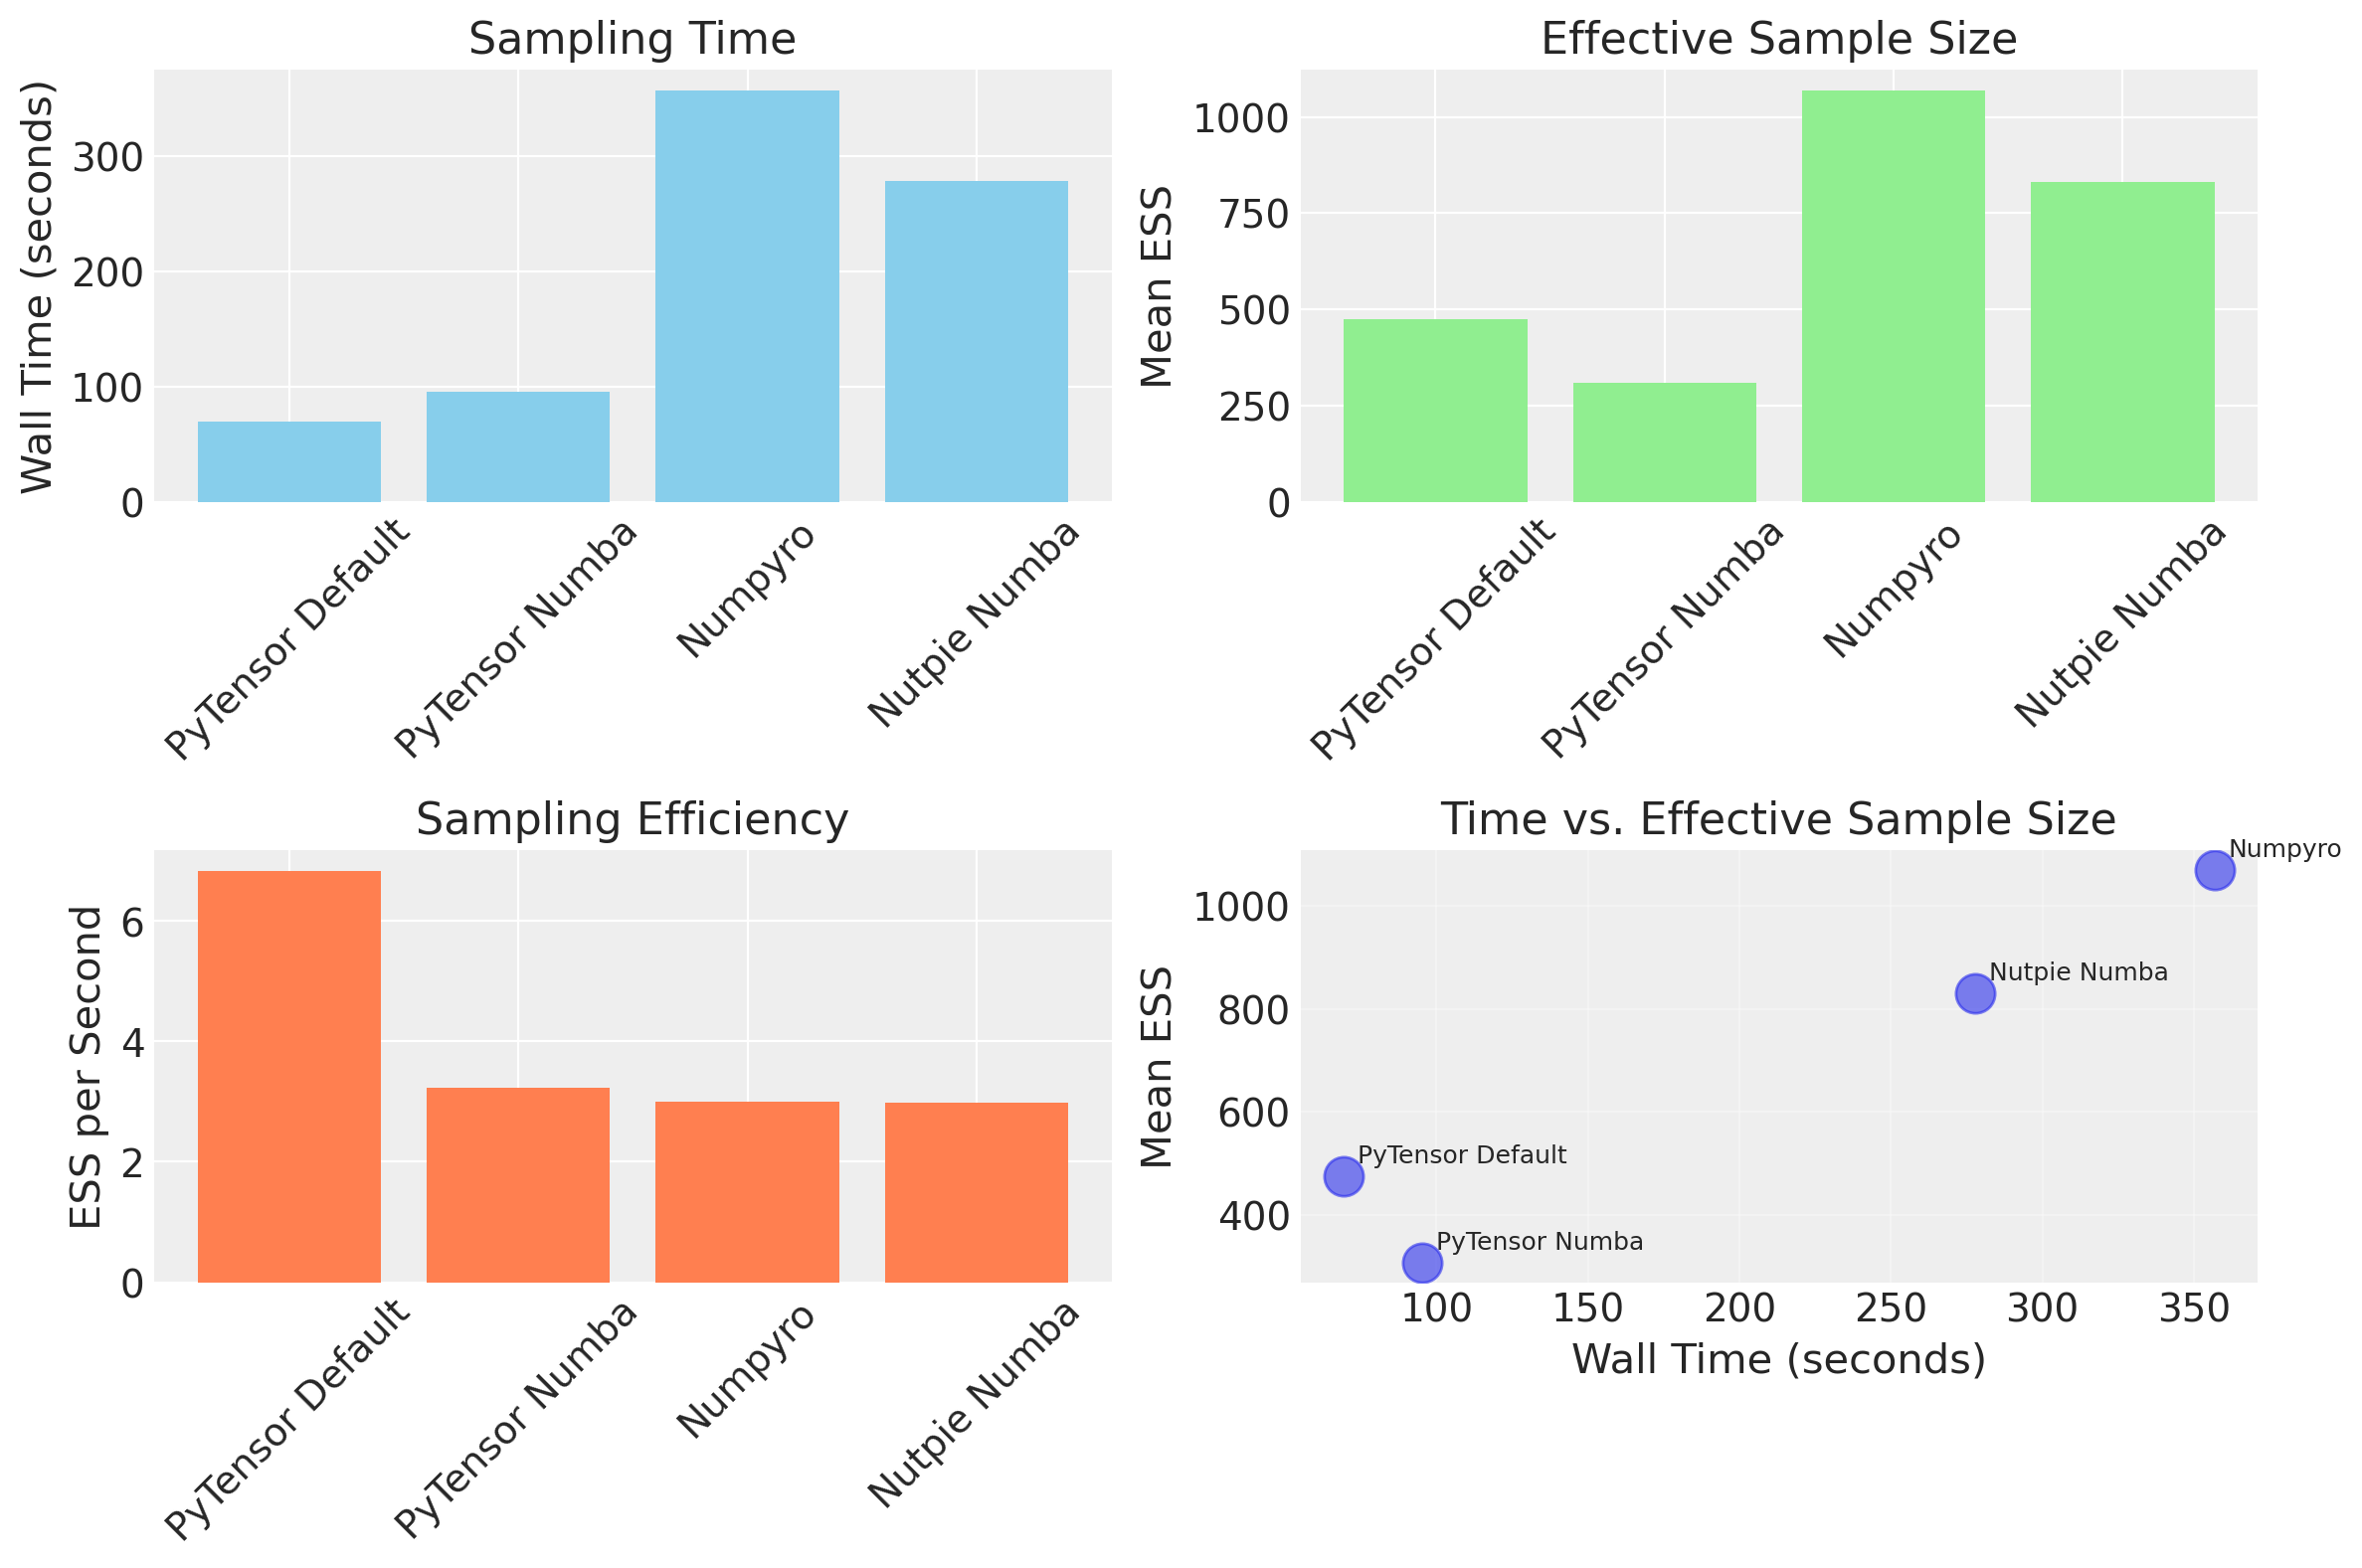

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Convert Polars DataFrame to lists for plotting
backends = df["Sampling Backend"].to_list()
wall_times = df["Wall Time (s)"].to_list()
mean_ess_values = df["Mean ESS"].to_list()
ess_per_sec_values = df["ESS/sec"].to_list()

ax1.bar(backends, wall_times, color="skyblue")
ax1.set_ylabel("Wall Time (seconds)")
ax1.set_title("Sampling Time")
ax1.tick_params(axis="x", rotation=45)

ax2.bar(backends, mean_ess_values, color="lightgreen")
ax2.set_ylabel("Mean ESS")
ax2.set_title("Effective Sample Size")
ax2.tick_params(axis="x", rotation=45)

ax3.bar(backends, ess_per_sec_values, color="coral")
ax3.set_ylabel("ESS per Second")
ax3.set_title("Sampling Efficiency")
ax3.tick_params(axis="x", rotation=45)

ax4.scatter(wall_times, mean_ess_values, s=200, alpha=0.6)
for i, backend in enumerate(backends):
    ax4.annotate(
        backend,
        (wall_times[i], mean_ess_values[i]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
    )
ax4.set_xlabel("Wall Time (seconds)")
ax4.set_ylabel("Mean ESS")
ax4.set_title("Time vs. Effective Sample Size")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Special Cases and Advanced Usage

### Using PyMC's Built-in Sampler with Different Backends

In certain scenarios, you may need to use PyMC's Python-based sampler while still benefiting from faster computational backends. This situation commonly arises when working with models that contain discrete variables, which require PyMC's specialized sampling algorithms. Even in these cases, you can significantly improve performance by compiling the model's computational graph to more efficient backends.

The following examples demonstrate how to use PyMC's built-in sampler with different compilation targets. The `fast_run` mode uses optimized C compilation, which provides good performance while maintaining full compatibility. The `numba` mode offers the only way to access Numba's just-in-time compilation benefits when using PyMC's sampler. The `jax` mode enables JAX compilation, though for JAX workflows, Nutpie or NumPyro typically provide better performance.


In [11]:
with gp_latent_model():
    idata_c = pm.sample(
        draws=n_draws,
        tune=n_tune,
        chains=n_chains,
        nuts_sampler="pymc",
        compile_kwargs={"mode": "fast_run"},
        progressbar=False,
    )

# with gp_latent_model():
#     idata_pymc_numba = pm.sample(draws=n_draws, tune=n_tune, chains=n_chains, nuts_sampler="pymc", compile_kwargs={"mode": "numba"}, progressbar=False)

# with gp_latent_model():
#     idata_pymc_jax = pm.sample(draws=n_draws, tune=n_tune, chains=n_chains, nuts_sampler="pymc", compile_kwargs={"mode": "jax"}, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ell, eta, f_rotated_, sigma, nu]
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 49 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See http

The above examples are commented out to avoid redundant sampling in this demonstration notebook. In practice, you would uncomment and run the configuration that matches your model's requirements. These compilation modes allow you to access faster computational backends even when you must use PyMC's Python-based sampler for compatibility reasons.


### Models with Discrete Variables

When working with models that contain discrete variables, you have no choice but to use PyMC's built-in sampler. This is because discrete variables require specialized sampling algorithms like Slice sampling or Metropolis-Hastings that are only available in PyMC's Python implementation. The example below demonstrates a typical scenario where this constraint applies.


In [18]:
# Example: Hierarchical Logistic Regression with Unknown Group Membership
# This is a realistic model where we have binary outcomes but don't know
# which latent group each observation belongs to


def generate_group_data(n_obs=200, n_groups=3, n_features=4, random_seed=42):
    """Generate synthetic data for hierarchical logistic regression with unknown groups"""
    rng = np.random.default_rng(random_seed)

    # True group assignments (unknown to the model)
    true_groups = rng.choice(n_groups, size=n_obs)

    # Group-specific intercepts and slopes
    true_intercepts = np.array([-1.5, 0.0, 1.2])  # Different baseline rates
    true_slopes = rng.normal(0, 0.8, size=(n_groups, n_features))

    # Generate features
    X = rng.standard_normal(size=(n_obs, n_features))

    # Generate outcomes based on true group membership
    y = np.zeros(n_obs, dtype=int)
    for i in range(n_obs):
        group = true_groups[i]
        logit_p = true_intercepts[group] + X[i] @ true_slopes[group]
        p = 1 / (1 + np.exp(-logit_p))
        y[i] = rng.binomial(1, p)

    return X, y, true_groups


# Generate data
X_discrete, y_discrete, true_groups = generate_group_data(n_obs=100, n_groups=3)
n_obs, n_features = X_discrete.shape
n_groups = 3

print(f"Generated {n_obs} observations with {n_features} features")
print(f"True group distribution: {np.bincount(true_groups)}")
print(f"Outcome distribution: {np.bincount(y_discrete)}")

# Hierarchical logistic regression with unknown group membership
with pm.Model() as discrete_mixture_model:
    # Group membership probabilities
    group_probs = pm.Dirichlet("group_probs", a=np.ones(n_groups))

    # Latent group assignments for each observation
    group_assignments = pm.Categorical("group_assignments", p=group_probs, shape=n_obs)

    # Hierarchical priors for group-specific parameters
    # Group-specific intercepts
    mu_intercept = pm.Normal("mu_intercept", 0, 2)
    sigma_intercept = pm.HalfNormal("sigma_intercept", 1)
    intercepts = pm.Normal("intercepts", mu_intercept, sigma_intercept, shape=n_groups)

    # Group-specific slopes
    mu_slopes = pm.Normal("mu_slopes", 0, 1, shape=n_features)
    sigma_slopes = pm.HalfNormal("sigma_slopes", 1, shape=n_features)
    slopes = pm.Normal("slopes", mu_slopes, sigma_slopes, shape=(n_groups, n_features))

    # Linear predictor using group assignments
    # This is where the discrete variables matter!
    linear_pred = intercepts[group_assignments] + pm.math.sum(
        slopes[group_assignments] * X_discrete, axis=1
    )

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", logit_p=linear_pred, observed=y_discrete)

    # Sample with compound step (Metropolis for discrete + NUTS for continuous)
    trace_discrete = pm.sample(
        chains=2, draws=125, tune=500, progressbar=False  # Smaller draws since this is more complex
    )

Generated 100 observations with 4 features
True group distribution: [27 33 40]
Outcome distribution: [56 44]


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [group_probs, mu_intercept, sigma_intercept, intercepts, mu_slopes, sigma_slopes, slopes]
>CategoricalGibbsMetropolis: [group_assignments]
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 2 chains for 500 tune and 125 draw iterations (1_000 + 250 draws total) took 6 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for 

## Authors

- Originally authored by Thomas Wiecki in July 2023
- Updated and expanded by Chris Fonnesbeck in May 2025


In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,arviz,pymc,numpnutpie

Last updated: Sat Jun 14 2025

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.2.0

pytensor: 2.30.3
arviz   : 0.21.0
pymc    : 5.22.0
numpyro : 0.18.0
blackjax: 0.0.0
nutpie  : 0.14.3

pymc      : 5.22.0
pandas    : 2.2.3
arviz     : 0.21.0
numpyro   : 0.18.0
matplotlib: 3.10.3
numpy     : 2.2.6

Watermark: 2.5.0

